In [ ]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import detrend
from scipy.stats import gaussian_kde, weightedtau, kendalltau, pearsonr, spearmanr
%matplotlib inline

In [ ]:
HOMEDIR = Path('/scistor/ivm/jsn295/')
sys.path.append(str(HOMEDIR))
from Weave.src.utils import agg_time
from SubSeas.helper_functions import monthtoseasonlookup

In [ ]:
response = xr.open_dataarray(HOMEDIR / 'processed/t2m_europe.anom.nc')
clusterfield = xr.open_dataarray(HOMEDIR / 'clusters/t2m-q095.nc').sel(nclusters = 14)
reduced = response.groupby(clusterfield).mean('stacked_latitude_longitude')
reduced = reduced.sel(clustid = 9)

In [ ]:
reduced.plot()

### Look at the sst patterns and z300 patterns

In [ ]:
sstcorr = xr.open_dataarray(HOMEDIR / 'correlation_roll_spearman/sst_nhplus.5.corr.nc', decode_times = False)
z300corr = xr.open_dataarray(HOMEDIR / 'correlation_roll_spearman/z300_nhmin.5.corr.nc', decode_times = False)

In [ ]:
sstcorr[0].plot()

In [ ]:
sstcorr.sel(latitude = 45, longitude = -30, method = 'nearest').plot()

In [ ]:
sstcorr.sel(latitude = 37, longitude = -50, method = 'nearest').plot()

In [ ]:
sstcorr.sel(latitude = 43, longitude = 4.3, method = 'nearest').plot()

In [ ]:
sstcoords = pd.DataFrame({'latitude':[37,45,43],
                      'longitude':[-50,-30,4.3]},
                     index = pd.Index(['athot','atcold','medhot'], name = 'location'))

In [ ]:
sstcoords

In [ ]:
z300corr[4].plot()

In [ ]:
z300corr[0].plot()

In [ ]:
z300corr.sel(latitude = 50, longitude = 60, method = 'nearest').plot()

In [ ]:
z300corr.sel(latitude = 30, longitude = 60, method = 'nearest').plot()

In [ ]:
z300coords = pd.DataFrame({'latitude':[50,30],
                      'longitude':[60,60]},
                     index = pd.Index(['kzlow','irhigh'], name = 'location'))

In [ ]:
z300coords

In [ ]:
coords = pd.concat([sstcoords, z300coords], axis = 0, keys = ['sst','z300'], names = ['variable','location'])

In [ ]:
sstcorr.close()
z300corr.close()
coords

### Take these coords to extract unaggregated anomalie timeseries
And then investigate their (lagged / aggregated) properties and dependencies with the reduced response

In [ ]:
data = {}
for ind, cords in coords.groupby(['variable','location']):
    array =  xr.open_dataarray((HOMEDIR / 'processed/sst_nhplus.anom.nc') if ind[0] == 'sst' else (HOMEDIR / 'processed/z300_nhmin.anom.nc'))
    #print(array.sel(latitude = cords['latitude'][0], longitude = cords['longitude'][0], method = 'nearest').values)
    data.update({ind:array.sel(latitude = cords['latitude'][0], longitude = cords['longitude'][0], method = 'nearest').values})
    data.update({('time',''):array.coords['time'].values})
    array.close()

In [ ]:
test = pd.DataFrame(data)
test = test.set_index('time')
test.loc[:,('t2m','westeur')] = reduced.values

First check, concurrent and summer only

In [ ]:
summer = test.loc[monthtoseasonlookup(test.index.month) == 'JJA',:]

In [ ]:
summer.hist()

So clearly the geopotential heigths are not really normally distributed within summer. Potentially due to a large trend?

In [ ]:
summer.loc[:,('z300','irhigh')].plot()

In [ ]:
summer_det = summer.copy()
summer_det.loc[:,:] = detrend(summer_det, axis = 0)
summer_det.hist()

In [ ]:
np.round(np.corrcoef(summer, rowvar = False), 3)

In [ ]:
summer_det.plot.scatter(x = -4, y = -1)

### Now we go back to the full timeseries to make a lagging + aggregating + dependence

In [ ]:
temp = test.copy()
tempxr = xr.DataArray(temp)

In [ ]:
aggregated = agg_time(tempxr, ndayagg = 5, rolling = True)
agg = aggregated[aggregated.time.dt.season == 'JJA',:].to_pandas()

In [ ]:
agg.plot.scatter(x = -2, y = -1)

In [ ]:
np.round(np.corrcoef(agg,rowvar = False), 4)

In [ ]:
bi_var = agg.loc[:,(slice(None),['kzlow','westeur'])]
bi_var_transp = bi_var.values.T
z = gaussian_kde(dataset=bi_var_transp)(bi_var_transp)
idx = z.argsort()

In [ ]:
x = bi_var_transp[0,:][idx]
y = bi_var_transp[1,:][idx]
z = z[idx]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10, edgecolor=None)
plt.show()

In [ ]:
def density_plot(xy, ax, xlabel = None, ylabel = None, title = None, annotations: dict = None):
    """
    shape (2,n_obs), with x on [0,:] and y on [1,:]
    """
    z = gaussian_kde(dataset=xy)(xy)
    idx = z.argsort()
    x = xy[0,:][idx]
    y = xy[1,:][idx]
    z = z[idx]
    ax.scatter(x, y, c=z, s=10, edgecolor=None)
    if not xlabel is None:
        ax.set_xlabel(xlabel)
    if not ylabel is None:
        ax.set_ylabel(ylabel)
    if not title is None:
        ax.set_title(title)
    if not annotations is None:
        ys = list(np.arange(0.1, 0.1* len(annotations), 0.1))
        for key, val in annotations.items():
            ax.annotate(s = f'{key},{val}', xy = (0.1,ys.pop()), xycoords = 'axes fraction', color = 'r')
    return ax
    
#aggregated = agg_time(tempxr, ndayagg = 5, rolling = True)
# Aggregation controls. For a single aggregation I want to make series of scatterplots at multiple lags. For one variable.
def lag_and_plot_pair(aggarr, laglist, x = ('z300','kzlow'), y = ('t2m','westeur'), detr = False):
    """
    Is supplied with the aggregated array (outcome of agg_time), does lagging with xarray
    laglist is in days 
    Then subsetting and plotting the scatter    
    """
    aggarr = aggarr.copy()
    oritimeaxis = aggarr.coords['time']
    start = pd.Timestamp(oritimeaxis[0].values).strftime('%Y-%m-%d')
    yvals = aggarr.sel(dim_1 = y)[aggarr.time.dt.season == 'JJA']
    fig, axes = plt.subplots(ncols = len(laglist), figsize = (4*len(laglist),3))
    for lag in laglist:
        aggarr['time'] = oritimeaxis - pd.Timedelta(str(lag) + 'D')
        print(f'lag: {lag} assigns {pd.Timestamp(aggarr["time"][0].values).strftime("%Y-%m-%d")} to xvalue at {start}')
        xvals = aggarr.sel(dim_1 = x).reindex_like(yvals)
        xy = np.vstack([xvals.values, yvals.values])
        if detr:
            xy = detrend(xy, axis = 1)
        axes[laglist.index(lag)] = density_plot(xy, ax = axes[laglist.index(lag)], xlabel = x, ylabel = y, title = f'lag {lag} [days], detr: {detr}')
        
    plt.show()

#lag_and_plot_pair(aggregated, laglist = [0,-1,-3,-5,-7,-10])

lag: 0 assigns 1979-01-01 to xvalue at 1979-01-01
lag: -1 assigns 1979-01-02 to xvalue at 1979-01-01
lag: -3 assigns 1979-01-04 to xvalue at 1979-01-01
lag: -5 assigns 1979-01-06 to xvalue at 1979-01-01
lag: -7 assigns 1979-01-08 to xvalue at 1979-01-01
lag: -10 assigns 1979-01-11 to xvalue at 1979-01-01


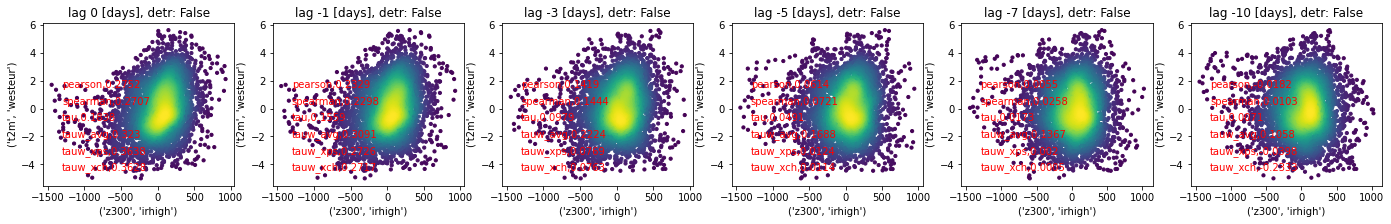

In [157]:
lag_and_plot_pair(aggregated, laglist = [0,-1,-3,-5,-7,-10], x=('z300','irhigh'))

lag: -1 assigns 1979-01-02 to xvalue at 1979-01-01
lag: -3 assigns 1979-01-04 to xvalue at 1979-01-01
lag: -5 assigns 1979-01-06 to xvalue at 1979-01-01
lag: -7 assigns 1979-01-08 to xvalue at 1979-01-01
lag: -10 assigns 1979-01-11 to xvalue at 1979-01-01
lag: -20 assigns 1979-01-21 to xvalue at 1979-01-01
lag: -30 assigns 1979-01-31 to xvalue at 1979-01-01


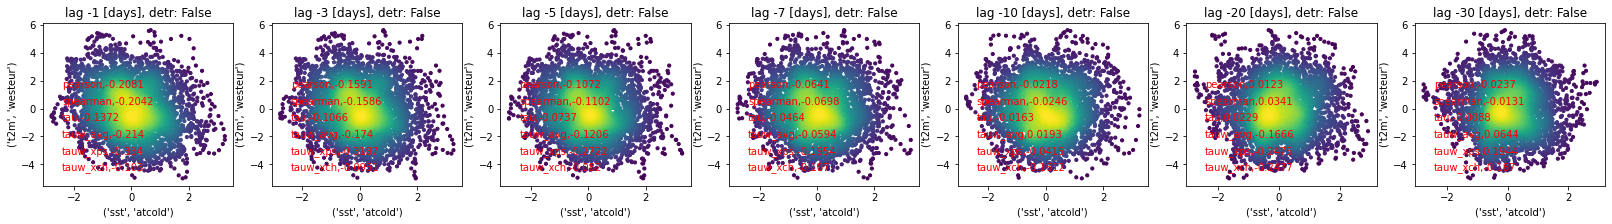

In [155]:
lag_and_plot_pair(aggregated, laglist = [-1,-3,-5,-7,-10,-20,-30], x=('sst','atcold'))

Interestingly you see the rolling aggregation in the fact that there are trajectories in the outliers. I wonder how the plots will change with different aggregation periods and with a detrending. Perhaps the dense yellow blob disappears. Detrending will have most influence if the trend is different in both (sign or absent/present)

Let's check detrending

In [ ]:
lag_and_plot_pair(aggregated, laglist = [-1,-3,-5,-7,-10,-20,-30], x=('sst','atcold'), detr = True)

In [ ]:
column = 0
print(kendalltau(agg.iloc[:,column],agg.iloc[:,-1]))
print(weightedtau(agg.iloc[:,column],agg.iloc[:,-1]))
print(np.corrcoef(agg.iloc[:,[column,-1]], rowvar = False))

In [ ]:
# Ranking by the temperature only, or both?
from scipy.stats import rankdata
ranks = rankdata(agg.iloc[:,-1], method = 'ordinal')
ranks = ranks.max() - ranks # Zero is the largest element
ranksx = rankdata(agg.iloc[:,column], method = 'ordinal') # Negative relation for the variable so we want extreme low to be most important.
print(weightedtau(x = agg.iloc[:,column], y = agg.iloc[:,-1], rank=ranks))
print(weightedtau(x = agg.iloc[:,-1], y = agg.iloc[:,column], rank=None)) # From documentation: if rank = None then Elements with larger x values will have more importance. Positive response tail
print(weightedtau(x = agg.iloc[:,column], y = agg.iloc[:,-1], rank=None)) # Letting the precursor be the importance variable (positive tailed)
print(weightedtau(x = agg.iloc[:,column], y = agg.iloc[:,-1], rank=ranksx)) # Explicit precursor importantce (negative tailed)
print(weightedtau(x = agg.iloc[:,-1], y = agg.iloc[:,column], rank=ranksx)) # Explicit precursor importantce (negative tailed)
print(weightedtau(x = agg.iloc[:,-1], y = agg.iloc[:,column], rank=True)) 

In [156]:
# Ranking by precursor (standard postitive), ranking by precursor (choice), mixture, unweighted, pearson, spearman
def rankdirection(x,y):
    """
    Returns a rank array (0 most important) with emphasis on negative x when negative relation
    emphasis on positive x when positive overall relation
    """
    ranks = rankdata(x, method = 'ordinal')
    if pearsonr(x = x, y = y)[0] < 0:
        return ranks
    else:
        return ranks.max() - ranks

def generate_corrs(x,y):
    corrs = {}
    corrs['pearson'] = pearsonr(x = x, y = y)[0]
    corrs['spearman'] = spearmanr(a = x, b = y)[0]
    corrs['tau'] = kendalltau(x,y)[0]
    corrs['tauw_avg'] = weightedtau(x = x, y = y, rank=True)[0]
    corrs['tauw_xps'] = weightedtau(x = x, y = y, rank=None)[0]
    corrs['tauw_xch'] = weightedtau(x = x, y = y, rank=rankdirection(x = x, y = y))[0]
    return {key: np.round(item, 4) for key, item in corrs.items()}

# Aggregation controls. For a single aggregation I want to make series of scatterplots at multiple lags. For one variable.
def lag_and_plot_pair(aggarr, laglist, x = ('z300','kzlow'), y = ('t2m','westeur'), detr = False):
    """
    Is supplied with the aggregated array (outcome of agg_time), does lagging with xarray
    laglist is in days 
    Then subsetting and plotting the scatter    
    """
    aggarr = aggarr.copy()
    oritimeaxis = aggarr.coords['time']
    start = pd.Timestamp(oritimeaxis[0].values).strftime('%Y-%m-%d')
    yvals = aggarr.sel(dim_1 = y)[aggarr.time.dt.season == 'JJA']
    fig, axes = plt.subplots(ncols = len(laglist), figsize = (4*len(laglist),3))
    for lag in laglist:
        aggarr['time'] = oritimeaxis - pd.Timedelta(str(lag) + 'D')
        print(f'lag: {lag} assigns {pd.Timestamp(aggarr["time"][0].values).strftime("%Y-%m-%d")} to xvalue at {start}')
        xvals = aggarr.sel(dim_1 = x).reindex_like(yvals)
        xy = np.vstack([xvals.values, yvals.values])
        if detr:
            xy = detrend(xy, axis = 1)
        corrs = generate_corrs(x = xy[0,:], y = xy[1,:])
        axes[laglist.index(lag)] = density_plot(xy, ax = axes[laglist.index(lag)], xlabel = x, ylabel = y, title = f'lag {lag} [days], detr: {detr}', annotations = corrs)
        
    plt.show()


In [ ]:
corrs = generate_corrs(x = agg.iloc[:,column], y = agg.iloc[:,-1])
rankdirection(x = agg.iloc[:,column], y = agg.iloc[:,-1])
aggregated = agg_time(tempxr, ndayagg = 5, rolling = True)
lag_and_plot_pair(aggregated, laglist = [0,-1,-3,-5,-7,-10])

In [ ]:
lag_and_plot_pair(aggregated, laglist = [0,-1,-3,-5,-7,-10], x = ('sst','atcold'), detr = True)

In [ ]:
ranksx

In [ ]:
# In the end some sort of matrix plot with aggregations and lags? One variable, multiple measures.
agg.iloc[:,column]